![SegmentLocal](images/optimization_algos.gif "segment")

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim.optimizer import Optimizer

/home/suzy/miniconda3/envs/lappt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class NN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, init=True):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_dim, out_features=hid_dim)
        self.fc2 = nn.Linear(in_features=hid_dim, out_features=hid_dim)
        self.fc3 = nn.Linear(in_features=hid_dim, out_features=out_dim)
        if init:
            self.init_params()

    def forward(self, x):
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

    def init_params(self):
        for n, p in self.named_parameters():
            if "weight" in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

In [3]:
class CustomSGD(Optimizer):
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

In [4]:
class CustomSGDMomentum(Optimizer):
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * v)

In [5]:
class CustomAdagrad(Optimizer):
    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            acc_sqr_grad.add_(param.grad * param.grad)
            std = acc_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [6]:
def train(dataloader, model, device, optimizer, criterion, epochs):
    step_losses = []
    model.train()

    for epoch in range(epochs):
        batch_losses = []
        for img, lbl in tqdm(dataloader):
            img, lbl = [x.to(device) for x in [img, lbl]]
            
            optimizer.zero_grad()
            pred = model(img)
            loss = criterion(pred, lbl)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        step_losses.extend(batch_losses)
    return step_losses

In [7]:
mean, std = 0.1307, 0.3081
bs, nw = 128, 32

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (std, ))
])

train_dataset = torchvision.datasets.MNIST(".", train = True, transform = train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size = bs, shuffle = True, num_workers = nw)

in_dim = 28 * 28
hid_dim = 256
out_dim = 10

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model_sgd = NN(in_dim, hid_dim, out_dim)
model_sgd = model_sgd.to(device)
optim_sgd = CustomSGD(model_sgd.parameters())

model_sgd_mom = NN(in_dim, hid_dim, out_dim)
model_sgd_mom = model_sgd_mom.to(device)
optim_sgd_mom = CustomSGDMomentum(model_sgd_mom.parameters())

model_ada = NN(in_dim, hid_dim, out_dim)
model_ada = model_ada.to(device)
optim_ada = CustomAdagrad(model_ada.parameters())

criterion = nn.CrossEntropyLoss()

sgd_loss = train(train_loader, model_sgd, device, optim_sgd, criterion, 5)
sgd_momentum_loss = train(train_loader, model_sgd_mom, device, optim_sgd_mom, criterion, 5)
adagrad_loss = train(train_loader, model_ada, device, optim_ada, criterion, 5)

100%|██████████| 469/469 [00:03<00:00, 147.92it/s]


In [8]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

#plot_loss(sgd_loss, 'SGD with lr=1e-3')
#plt.savefig(os.path.join(os.path.abspath(os.getcwd()), "images", 'sgd.png'), dpi=300)

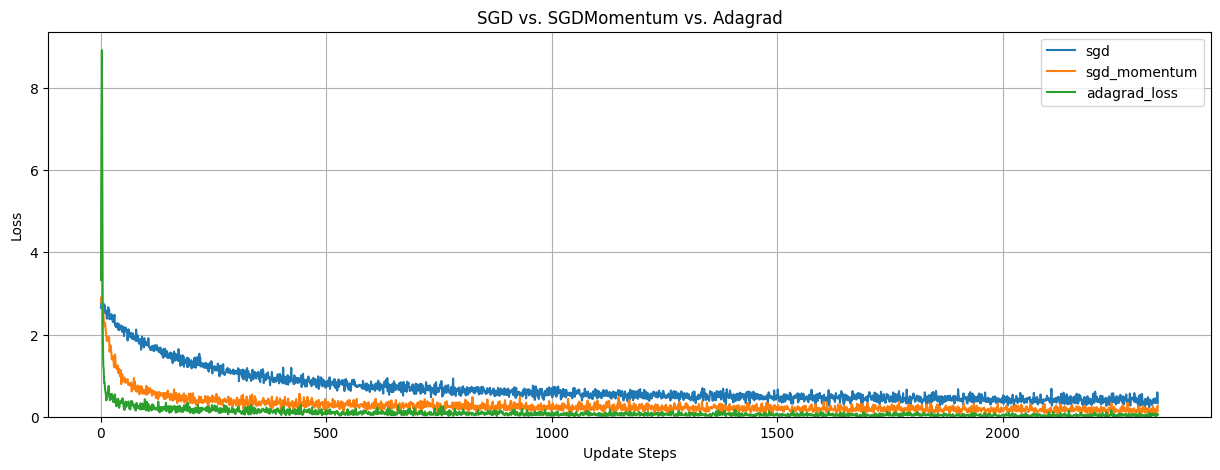

In [10]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""
    
    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')
    plt.savefig(os.path.join(os.path.abspath(os.getcwd()), "images", 'curves.png'), dpi=300)

# losses = [sgd_loss, sgd_momentum_loss]
# labels = ['sgd', 'sgd_momentum']

# plot_losses(losses, labels, 'SGD vs SGDMomentum')

losses = [sgd_loss, sgd_momentum_loss, adagrad_loss]
labels = ['sgd', 'sgd_momentum', 'adagrad_loss']

plot_losses(losses, labels, 'SGD vs. SGDMomentum vs. Adagrad')